# Engenharia de features para similaridade e funções de similaridade

Issue: [#244](https://github.com/lappis-unb/salic-ml/issues/244)

## Objetivos

Documentar a Engenharia de Features para Similaridade de projetos, assim como funções para estimar a similaridade entre dois projetos culturais. A similaridade aqui é em termos de estrutura dos projetos: itens, produtos, segmentos e áreas.

## Introdução

Este trabalho consiste em determinar um conjunto de features e analisar diferentes funções de similaridades de projetos para cada conjunto de features selecionado.

### Features

Nesta análise, consideramos subconjuntos de features (de um projeto) desta lista:

- Segmento
- Area
- Lista de produtos culturais. Considerar apenas idProduto != 0, pois idProduto são itens de "administração de projeto" como: refeição, hospedagem, passagem aérea, postagem, contador, combustível, salário
- List de itens orçamentŕios


**Considerando os produtos, sem os itens orçamentários**

Por conhecimento prévio do negócio, é sabido que a lista de produtos culturais do projeto é um dado importante dos projetos culturais, portanto não será feito uma análise que desconsidera estes dados. O mesmo pode ser afirmado sobre a área e o segmento dos projetos.

**Considerando os produtos, junto com os itens orçamentários**

Será considerado também a inclusão dos itens orçamentários.

### Algoritmos

1 - [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)

2 - Jaccard index com pesos

---
## Preparação

O dataset foi obtido a partir de uma query `.sql`, que está disponível na pasta `/data/scripts/` do projeto.

Nome do arquivo: `projects_similarity.sql`

#### Importando módulos e definindo constantes

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from core.utils.read_csv import read_csv

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.set_option('max_colwidth', 2000)

#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [3]:
planilha_name = 'planilha_orcamentaria_similaridade.csv'
df = read_csv(planilha_name)
df = df[df['idProduto'] != 0]
display(df.dtypes)
df.head()

idPronac                int64
PRONAC                  int64
idPlanilhaAprovacao     int64
Item                   object
idPlanilhaItens         int64
idArea                  int64
Area                   object
idSegmento             object
Segmento               object
idProduto               int64
Produto                object
DataProjeto            object
dtype: object

,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto
0,137909,114494,238625,Banner/faixa adesiva/faixa de lona/saia de palco/testeira/pórtico\r\n,2743,2,Audiovisual,26,Produção Cinematográfica de média metragem,12,DVD,2011-06-06 10:33:40
1,111339,90226,136160,Mídia impressa,178,7,Artes Integradas,71,Artes Integradas,1,Livro,2009-03-13 11:25:24
2,115426,94229,103912,Restauração / Conservação,2584,5,Patrimônio Cultural,56,Acervos Museológicos,67,Bem Móvel - Restauração / Preservação / Aquisição,2009-08-05 11:33:24
3,115426,94229,103914,Restauração / Conservação,2584,5,Patrimônio Cultural,56,Acervos Museológicos,67,Bem Móvel - Restauração / Preservação / Aquisição,2009-08-05 11:33:24
4,115426,94229,103918,Restauração / Conservação,2584,5,Patrimônio Cultural,56,Acervos Museológicos,67,Bem Móvel - Restauração / Preservação / Aquisição,2009-08-05 11:33:24


### Extraindo features de produto

**Features**:

- idSegmento

- idArea

- Produtos

- Itens orçamentários

In [4]:
PRODUCT_COLUMNS = ['PRONAC', 'idPronac', 'idSegmento', 'idArea', 'idProduto', 'idPlanilhaItens']
df_products = df[PRODUCT_COLUMNS]

display(df_products.head())

,PRONAC,idPronac,idSegmento,idArea,idProduto,idPlanilhaItens
0,114494,137909,26,2,12,2743
1,90226,111339,71,7,1,178
2,94229,115426,56,5,67,2584
3,94229,115426,56,5,67,2584
4,94229,115426,56,5,67,2584


In [5]:
products_group = df_products.groupby(['PRONAC'])

for pronac, group in products_group:
    id_segmento = group.iloc[0]['idSegmento']
    id_area = group.iloc[0]['idArea']
    id_pronac = group.iloc[0]['idPronac']
    products_unique = group.idProduto.unique()
    products = group.idProduto.values
    
    print('PRONAC = {}'.format(pronac))
    print('idPronac = {}'.format(id_pronac))
    print('id_segmento = {}'.format(id_segmento))
    print('id_area = {}'.format(id_area))
    print('products_unique = {}'.format(products_unique))
    print('products = {}'.format(products))

    
    break

PRONAC = 90105
idPronac = 111218
id_segmento = 11
id_area = 1
products_unique = [19]
products = [19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19]


### Segmentos mais comuns

In [6]:
popular_segments = df[['PRONAC', 'idSegmento', 'idArea']].groupby(['PRONAC', 'idSegmento']).count()
popular_segments = popular_segments.groupby('idSegmento').count().sort_values(by='idArea', ascending=False)
display(popular_segments.head())

,idArea
idSegmento,
11,9793
31,4551
33,4338
4B,2659
12,2415


# Distribuição do número de produtos por projeto

A média do número de produtos culturais é de 2.5 (ignorando produtos do tipo `Administração do Proeto`, `idProduto=0`), portanto utilizar a similaridade de Jaccard apenas nestas features pode enviesar os resultados: muitos projetos serão muito parecidos.

count    41616.000000
mean         1.548299
std          0.956948
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: idProduto, dtype: float64

Text(0, 0.5, 'Número de projetos')

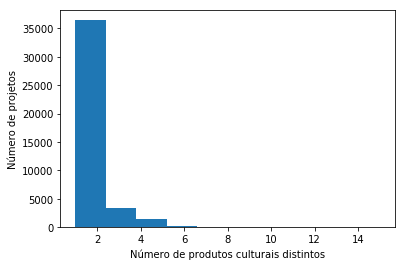

In [7]:
nunique_products = df[['PRONAC', 'idProduto']].groupby('PRONAC').nunique()
display(nunique_products['idProduto'].describe())
plt.hist(nunique_products.idProduto.values)
plt.xlabel('Número de produtos culturais distintos')
plt.ylabel('Número de projetos')

# Definindo e testando uma função de similaridade

### Features:
    - área do projeto
    - segmento do projeto
    - lista de produtos culturais (!= 0) do projeto

### Função de similaridade:
    - Jaccard index nas features acima

**Extraindo features de um pronac**

In [8]:
def get_products_features(pronac):
    group = products_group.get_group(pronac)
    id_segmento = group.iloc[0]['idSegmento']
    id_area = group.iloc[0]['idArea']
    products = group.idProduto.unique()
    features = {
        'id_segmento': [id_segmento],
        'id_area': [id_area],
        'products': list(products),
    }
    return features

display(get_products_features(138478))

{'id_segmento': ['4B'],
 'id_area': [4],
 'products': [62, 115, 67, 3, 121, 2, 27, 81, 11, 50, 38, 16, 8]}

**Implementando o Jaccard Index**

In [9]:
def jaccard_collections_similarity(a, b):
    '''Assumes that all sets in a are disjoint, as well as all sets in b'''
    assert isinstance(a, list)
    assert isinstance(b, list)
    assert len(a) == len(b)

    intersects = [np.intersect1d(a[i], b[i]).size for i in range(len(a))]
    unions = [np.union1d(a[i], b[i]).size for i in range(len(a))]
    return sum(intersects) / sum(unions)

def jaccard_similarity(a, b):
    assert isinstance(a, list)
    assert isinstance(b, list)
    
    intesect_size = np.intersect1d(a, b).size
    union_size = np.union1d(a, b).size
    return intesect_size / union_size

def simple_similarity(a, b):
    return 1 if a == b else 0


'''Exemplos de teste'''
display(jaccard_collections_similarity([[1, 2], [3, 5, 7]], [[2], [5, 7]]))
display(jaccard_similarity([1, 2, 5], [5, 2]))
display(simple_similarity(5, 5))

0.6

0.6666666666666666

1

**Calculando a similaridade entre 2 projetos**

In [10]:
def pronacs_similarity(pronac1, pronac2):
    features = [list(get_products_features(pronac).values()) for pronac in [pronac1, pronac2]]
    sim = jaccard_collections_similarity(*features)
    return sim

def debug_similarity(pronac1, pronac2):
    sim = pronacs_similarity(pronac1, pronac2)
    features1 = list(get_products_features(pronac1).values())
    features2 = list(get_products_features(pronac2).values())

    print('features1 = {}'.format(features1))
    print('features2 = {}'.format(features2))
    print('sim(pronac1, pronac2) = {}'.format(sim))
    
pronac1 = 110526
pronac2 = 112112
debug_similarity(pronac1, pronac2)

features1 = [['11'], [1], [19, 2, 1, 121]]
features2 = [['11'], [1], [19, 115, 1, 12, 50]]
sim(pronac1, pronac2) = 0.4444444444444444


In [11]:
def get_pronac_items(pronac):
    return list(df[df['PRONAC'] == pronac].idPlanilhaItens.unique())

In [12]:
pronac1 = 90105
pronac2 = 158191
debug_similarity(pronac1, pronac2)
jaccard_similarity(get_pronac_items(pronac1), get_pronac_items(pronac2))

features1 = [['11'], [1], [19]]
features2 = [['11'], [1], [19]]
sim(pronac1, pronac2) = 1.0


0.06451612903225806

### Um problema com as features (segmento, area, produtos)

Para estas features, a similaridade entre os pronac `90105` e `158191` é de `1.0`, valor máximo. Entretanto, a similaridade de Jaccard do seus conjuntos de itens é de `0.065`, um valor muitas vezes menor. Deveria estes projetos serem considerados muito similares?

# Definindo e testando uma função de similaridade

A comparação anterior, com as features (área, segmento, produtos) apresentou uma limitação: estas features podem ser exatamente iguais entre dois projetos comparados, mas os itens utilizados entre estes dois projetos serem bastante diferentes. Portanto, vamos testar uma análise onde consideramos também o conjunto dos itens da planilha.

### Features:
    - área do projeto
    - segmento do projeto
    - lista de produtos culturais (!= 0) do projeto
    - lista de itens orçamentários (produto != 0) do projeto

### Função de similaridade:
    - Jaccard index nas features acima

**Filtrando as features de um pronac**

In [13]:
def get_products_items_features(pronac):
    group = products_group.get_group(pronac)
    id_segmento = group.iloc[0]['idSegmento']
    id_area = group.iloc[0]['idArea']
    products = group.idProduto.unique()
    items = group.idPlanilhaItens.unique()
    features = {
        'pronac': pronac,
        'id_segmento': [id_segmento],
        'id_area': [id_area],
        'products': sorted(list(products)),
        'items': sorted(list(items)),
    }
    return features

def get_products_items_features_df(df):
    id_segmento = df.iloc[0]['idSegmento']
    id_area = df.iloc[0]['idArea']
    pronac = df.iloc[0]['PRONAC']
    products = df.idProduto.unique()
    items = df.idPlanilhaItens.unique()
    features = {
        'pronac': pronac,
        'id_segmento': [id_segmento],
        'id_area': [id_area],
        'products': sorted(list(products)),
        'items': sorted(list(items)),
    }
    return features

print(get_products_items_features(110667))
print(get_products_items_features_df(products_group.get_group(110667)))

{'pronac': 110667, 'id_segmento': ['11'], 'id_area': [1], 'products': [132], 'items': [53, 88, 129, 134, 144, 150, 178, 179, 201, 1119, 1129, 2357, 2574, 2611, 2726, 2743, 3097, 3235, 3546, 3650, 3677, 3740, 3745, 4882]}
{'pronac': 110667, 'id_segmento': ['11'], 'id_area': [1], 'products': [132], 'items': [53, 88, 129, 134, 144, 150, 178, 179, 201, 1119, 1129, 2357, 2574, 2611, 2726, 2743, 3097, 3235, 3546, 3650, 3677, 3740, 3745, 4882]}


In [14]:
def pronacs_similarity(pronac1, pronac2):
    features = [list(get_products_items_features(pronac).values()) for pronac in [pronac1, pronac2]]
    sim = jaccard_collections_similarity(*features)
    return sim

def debug_similarity(pronac1, pronac2):
    sim = pronacs_similarity(pronac1, pronac2)
    features1 = list(get_products_items_features(pronac1).values())
    features2 = list(get_products_items_features(pronac2).values())

    print('features1 = {}'.format(features1))
    print('features2 = {}'.format(features2))
    print('sim(pronac1, pronac2) = {}'.format(sim))
    
pronac1 = 90105
pronac2 = 158191
debug_similarity(pronac1, pronac2)

features1 = [90105, ['11'], [1], [19], [12, 22, 23, 24, 27, 40, 49, 53, 57, 61, 62, 63, 66, 67, 68, 71, 72, 73, 74, 75, 81, 83, 85, 117, 118, 134, 142, 143, 144, 150, 178, 179, 1002, 1037, 1050, 1120, 1219, 2605, 2611, 2620, 2631, 2632, 2633, 2634, 2639, 2667, 2695, 2715]]
features2 = [158191, ['11'], [1], [19], [17, 57, 77, 78, 109, 142, 160, 1002, 1043, 1069, 1172, 1219, 2502, 2743, 2768, 3589, 3617, 3953]]
sim(pronac1, pronac2) = 0.1044776119402985


### Análise do teste com as features (segmento, area, produtos, itens)

Adicionando a feature da lista de itens, a similaridade foi de `1.0` para `0.11`, entre os pronac `90105` e `158191`. A similaridade abaixou, como o esperado.

É importante observar que cada elemento das features `segmento, àrea, produtos` possuem o mesmo peso do que um elemento da feature `lista de itens`. Porém, na média, o tamanho da `lista de itens` é muito maior do que a `lista de produtos`, assim também como é muito maior do que a `lista de àrea ou segmento` (ambas possuem tamanho=1). Portanto, uma melhoria possível para esta função é dar pesos diferentes para estas features.

# Definindo e testando uma função de similaridade

O objetivo agora é pesos as features `segmento, àrea, lista de produtos, lista de itens`.

O Jaccard Index na sua versão pura não dá peso aos elementos dos conjuntos comparados. Porém podemos tentar dar peso as features e aproveitar a ideia do Jaccard Index.

### Features:
    - área do projeto
    - segmento do projeto
    - lista de produtos culturais (!= 0) do projeto
    - lista de itens orçamentários (produto != 0) do projeto

### Função de similaridade:
  
Seja `sim(p1, p2)` a função que calcule a similaridade entre os projetos `p1, p2`.

```
sim(p1, p2) = a * jaccard(area_p1, area_p2) +
              s * jaccard(segmento_p1, segmento_p2) +
              i * jaccard(itens_p1, itens_p2) +
              p * jaccard(produtos_p1, produtos_p2)
```

Note que é possível normalizar a função acima, pois com certeza ela está no limite `[0, sum(a, s, i, p)`, portanto se quisermos um valor entre `[0, 1]` basta fazer `sim(p1, p2) / sum(a, s, i, p)]`.

Abaixo segue um exemplo para:

```
a = 1.0
s = 1.0
i = 3.0
p = 5.0
```

In [15]:
def pronacs_weighted_similarity(pronac1=None, pronac2=None, features=None):
    if features is None:
        features = [get_products_items_features(pronac) for pronac in [pronac1, pronac2]]
        
    FEATURE_WEIGHT = {
        'id_area': 1.0,
        'id_segmento': 1.0,
        'items': 3.0,
        'products': 5.0,
    }
        
    similarity = 0.0
    for feature, weight in FEATURE_WEIGHT.items():
        sim = jaccard_similarity(features[0][feature], features[1][feature])
        similarity += (weight * sim)
        
    weight_sum = np.sum(list(FEATURE_WEIGHT.values()))
    return similarity / weight_sum


        

pronac1 = 90105
pronac2 = 158191
sim = pronacs_weighted_similarity(pronac1, pronac2)
print('features_p1 = {}\n'.format(get_products_items_features(pronac1)))
print('features_p2 = {}\n'.format(get_products_items_features(pronac2)))
print('pronacs_weighted_similarity(1, 2) = {}'.format(sim))

features_p1 = {'pronac': 90105, 'id_segmento': ['11'], 'id_area': [1], 'products': [19], 'items': [12, 22, 23, 24, 27, 40, 49, 53, 57, 61, 62, 63, 66, 67, 68, 71, 72, 73, 74, 75, 81, 83, 85, 117, 118, 134, 142, 143, 144, 150, 178, 179, 1002, 1037, 1050, 1120, 1219, 2605, 2611, 2620, 2631, 2632, 2633, 2634, 2639, 2667, 2695, 2715]}

features_p2 = {'pronac': 158191, 'id_segmento': ['11'], 'id_area': [1], 'products': [19], 'items': [17, 57, 77, 78, 109, 142, 160, 1002, 1043, 1069, 1172, 1219, 2502, 2743, 2768, 3589, 3617, 3953]}

pronacs_weighted_similarity(1, 2) = 0.7193548387096774


# Matriz de similaridade entre projetos aleatórios

In [16]:
def similarity_matrix(similarity_function):
    SAMPLE_SIZE = 100
    pronacs = np.random.choice(df_products.PRONAC.unique(), size = SAMPLE_SIZE)

    sim_matrix = np.zeros((pronacs.size, pronacs.size))
    display(sim_matrix)

    for i in range(pronacs.size):
        pronac1 = pronacs[i]
        features1 = get_products_items_features(pronac1)

        for j in range(pronacs.size):
            pronac2 = pronacs[j]
            features2 = get_products_items_features(pronac2)

            sim = similarity_function(features=(features1, features2))
            sim_matrix[i][j] = sim

    df_sim_matrix = pd.DataFrame(sim_matrix)
    df_sim_matrix.describe()
    return sim_matrix

# HIstograma das células da matriz de similaridade

Consideramos apenas elementos da matriz triangular superior (`i < j`)

In [17]:
def matrix_upper_triangle(matrix, n):
    array = []
    for i in range(n):
        for j in range(i + 1, n):
            array.append(matrix[i][j])
    return array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

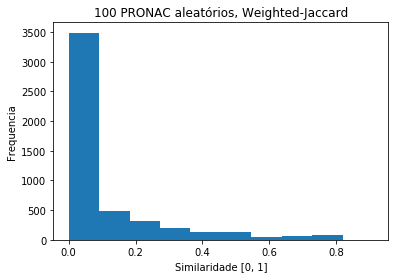

In [18]:
sim_matrix = similarity_matrix(pronacs_weighted_similarity)
pronacs = df_products.PRONAC.unique()
sim_array = matrix_upper_triangle(sim_matrix, 100)

plt.hist(sim_array)
plt.xlabel('Similaridade [0, 1]')
plt.ylabel('Frequencia')
plt.title('100 PRONAC aleatórios, Weighted-Jaccard')
plt.show()

In [19]:
def find_k_most_simillar(pronac, similarity_function, k=5):
    pronacs_group = df_products.groupby(['PRONAC'])
    features1 = get_products_items_features(pronac)
    similarities_set = set()
    for pronac2, items in pronacs_group:
        if pronac2 == pronac:
            continue
            
        features2 = get_products_items_features_df(items)
        sim = similarity_function(features=(features1, features2))
        similarities_set.add((sim, pronac2))
        
        if len(similarities_set) > k:
            similarities_set.remove(min(similarities_set))
    return similarities_set

pronac = 132200
display(find_k_most_simillar(pronac, pronacs_weighted_similarity, k=5))

{(0.85625, 148504),
 (0.8574257425742575, 163855),
 (0.8718446601941746, 111664),
 (0.922680412371134, 148120),
 (0.9305263157894735, 1310060)}

In [20]:
def find_idpronac(pronac):
    return products_group.get_group(pronac).iloc[0]['idPronac']

display(find_idpronac(111664))

134867

In [21]:
def find_k_most_simillar_link(pronac, similarity_function, k=5):
    pd.options.display.max_columns = None
    sims = list(find_k_most_simillar(pronac, pronacs_weighted_similarity, k=5))
    similarities = [1.0] + [row[0] for row in sims]
    pronacs = [pronac] + [row[1] for row in sims]
    link_versalic = ['http://versalic.cultura.gov.br/#/projetos/{}'.format(p) for p in pronacs]
    link_salic = ['http://salic.cultura.gov.br/verprojetos?idPronac={}'.format(find_idpronac(p)) for p in pronacs]

    df = pd.DataFrame({
        'PRONAC': pronacs,
        'Similaridade [0, 1]': similarities,
        'Link Versalic': link_versalic,
        'Link Salic': link_salic,
    }).sort_values('Similaridade [0, 1]', ascending=False)
    return df

display(find_k_most_simillar_link(pronac, pronacs_weighted_similarity, k=5))

,PRONAC,"Similaridade [0, 1]",Link Versalic,Link Salic
0,132200,1.000000,http://versalic.cultura.gov.br/#/projetos/132200,http://salic.cultura.gov.br/verprojetos?idPronac=161649
4,1310060,0.930526,http://versalic.cultura.gov.br/#/projetos/1310060,http://salic.cultura.gov.br/verprojetos?idPronac=169994
2,148120,0.922680,http://versalic.cultura.gov.br/#/projetos/148120,http://salic.cultura.gov.br/verprojetos?idPronac=183061
5,111664,0.871845,http://versalic.cultura.gov.br/#/projetos/111664,http://salic.cultura.gov.br/verprojetos?idPronac=134867
1,163855,0.857426,http://versalic.cultura.gov.br/#/projetos/163855,http://salic.cultura.gov.br/verprojetos?idPronac=206639
3,148504,0.856250,http://versalic.cultura.gov.br/#/projetos/148504,http://salic.cultura.gov.br/verprojetos?idPronac=183449


# Achando os 5 projetos mais similares de cada um dos 10 pronacs selecionados

<u>Obs:</u> a primeira linha das tabelas abaixo é o projeto que estamos comparando, aquele que queremos achar os 5 mais similares. As demais 5 linhas são os projetos mais similares.

**Fonte dos PRONAC:**

- http://versalic.cultura.gov.br/#/proponentes/b1920ede92745e0f2ac44393feb5e0081bfdd79abb89a893b73196837995
- http://versalic.cultura.gov.br/#/proponentes/b87ac883122eb525d6df6d7233091fe412dcc59e22b579f7c5caedcb8c5e

**PRONACS:** `161117, 163339, 152189, 153504, 159134, 1510414, 140707, 146379, 132200, 148939`

http://salic.cultura.gov.br/verprojetos?idPronac=210334

In [23]:
selected_pronacs = [161117, 163339, 152189, 153504, 159134, 1510414, 140707, 146379, 132200, 148939]
for pronac in selected_pronacs:
    display(find_k_most_simillar_link(pronac, pronacs_weighted_similarity, k=5))

,PRONAC,"Similaridade [0, 1]",Link Versalic,Link Salic
0,161117,1.000000,http://versalic.cultura.gov.br/#/projetos/161117,http://salic.cultura.gov.br/verprojetos?idPronac=202753
5,152189,0.934146,http://versalic.cultura.gov.br/#/projetos/152189,http://salic.cultura.gov.br/verprojetos?idPronac=191997
3,148338,0.907143,http://versalic.cultura.gov.br/#/projetos/148338,http://salic.cultura.gov.br/verprojetos?idPronac=183283
4,148010,0.901220,http://versalic.cultura.gov.br/#/projetos/148010,http://salic.cultura.gov.br/verprojetos?idPronac=182951
1,148206,0.897802,http://versalic.cultura.gov.br/#/projetos/148206,http://salic.cultura.gov.br/verprojetos?idPronac=183147
2,159854,0.895652,http://versalic.cultura.gov.br/#/projetos/159854,http://salic.cultura.gov.br/verprojetos?idPronac=200080


,PRONAC,"Similaridade [0, 1]",Link Versalic,Link Salic
0,163339,1.000000,http://versalic.cultura.gov.br/#/projetos/163339,http://salic.cultura.gov.br/verprojetos?idPronac=206085
2,1412274,0.952439,http://versalic.cultura.gov.br/#/projetos/1412274,http://salic.cultura.gov.br/verprojetos?idPronac=187420
4,1412081,0.917582,http://versalic.cultura.gov.br/#/projetos/1412081,http://salic.cultura.gov.br/verprojetos?idPronac=187220
1,129817,0.902105,http://versalic.cultura.gov.br/#/projetos/129817,http://salic.cultura.gov.br/verprojetos?idPronac=158780
3,1412914,0.897143,http://versalic.cultura.gov.br/#/projetos/1412914,http://salic.cultura.gov.br/verprojetos?idPronac=188082
5,159134,0.890588,http://versalic.cultura.gov.br/#/projetos/159134,http://salic.cultura.gov.br/verprojetos?idPronac=199285


,PRONAC,"Similaridade [0, 1]",Link Versalic,Link Salic
0,152189,1.000000,http://versalic.cultura.gov.br/#/projetos/152189,http://salic.cultura.gov.br/verprojetos?idPronac=191997
5,161117,0.934146,http://versalic.cultura.gov.br/#/projetos/161117,http://salic.cultura.gov.br/verprojetos?idPronac=202753
1,159854,0.929787,http://versalic.cultura.gov.br/#/projetos/159854,http://salic.cultura.gov.br/verprojetos?idPronac=200080
3,148338,0.925843,http://versalic.cultura.gov.br/#/projetos/148338,http://salic.cultura.gov.br/verprojetos?idPronac=183283
2,1510414,0.911364,http://versalic.cultura.gov.br/#/projetos/1510414,http://salic.cultura.gov.br/verprojetos?idPronac=200658
4,1310467,0.905102,http://versalic.cultura.gov.br/#/projetos/1310467,http://salic.cultura.gov.br/verprojetos?idPronac=170458


,PRONAC,"Similaridade [0, 1]",Link Versalic,Link Salic
0,153504,1.000000,http://versalic.cultura.gov.br/#/projetos/153504,http://salic.cultura.gov.br/verprojetos?idPronac=193430
4,161117,0.882759,http://versalic.cultura.gov.br/#/projetos/161117,http://salic.cultura.gov.br/verprojetos?idPronac=202753
5,1510716,0.878125,http://versalic.cultura.gov.br/#/projetos/1510716,http://salic.cultura.gov.br/verprojetos?idPronac=200976
3,148010,0.878022,http://versalic.cultura.gov.br/#/projetos/148010,http://salic.cultura.gov.br/verprojetos?idPronac=182951
2,152189,0.876289,http://versalic.cultura.gov.br/#/projetos/152189,http://salic.cultura.gov.br/verprojetos?idPronac=191997
1,148206,0.872277,http://versalic.cultura.gov.br/#/projetos/148206,http://salic.cultura.gov.br/verprojetos?idPronac=183147


,PRONAC,"Similaridade [0, 1]",Link Versalic,Link Salic
0,159134,1.000000,http://versalic.cultura.gov.br/#/projetos/159134,http://salic.cultura.gov.br/verprojetos?idPronac=199285
2,1412274,0.892135,http://versalic.cultura.gov.br/#/projetos/1412274,http://salic.cultura.gov.br/verprojetos?idPronac=187420
4,163339,0.890588,http://versalic.cultura.gov.br/#/projetos/163339,http://salic.cultura.gov.br/verprojetos?idPronac=206085
3,1412081,0.890323,http://versalic.cultura.gov.br/#/projetos/1412081,http://salic.cultura.gov.br/verprojetos?idPronac=187220
5,152189,0.874194,http://versalic.cultura.gov.br/#/projetos/152189,http://salic.cultura.gov.br/verprojetos?idPronac=191997
1,129817,0.871429,http://versalic.cultura.gov.br/#/projetos/129817,http://salic.cultura.gov.br/verprojetos?idPronac=158780


,PRONAC,"Similaridade [0, 1]",Link Versalic,Link Salic
0,1510414,1.000000,http://versalic.cultura.gov.br/#/projetos/1510414,http://salic.cultura.gov.br/verprojetos?idPronac=200658
5,152189,0.911364,http://versalic.cultura.gov.br/#/projetos/152189,http://salic.cultura.gov.br/verprojetos?idPronac=191997
2,1310705,0.907692,http://versalic.cultura.gov.br/#/projetos/1310705,http://salic.cultura.gov.br/verprojetos?idPronac=170709
4,1310467,0.905435,http://versalic.cultura.gov.br/#/projetos/1310467,http://salic.cultura.gov.br/verprojetos?idPronac=170458
3,148010,0.903571,http://versalic.cultura.gov.br/#/projetos/148010,http://salic.cultura.gov.br/verprojetos?idPronac=182951
1,148338,0.903448,http://versalic.cultura.gov.br/#/projetos/148338,http://salic.cultura.gov.br/verprojetos?idPronac=183283


,PRONAC,"Similaridade [0, 1]",Link Versalic,Link Salic
0,140707,1.000000,http://versalic.cultura.gov.br/#/projetos/140707,http://salic.cultura.gov.br/verprojetos?idPronac=173355
5,1310467,0.886111,http://versalic.cultura.gov.br/#/projetos/1310467,http://salic.cultura.gov.br/verprojetos?idPronac=170458
3,1412914,0.880000,http://versalic.cultura.gov.br/#/projetos/1412914,http://salic.cultura.gov.br/verprojetos?idPronac=188082
2,1412274,0.878302,http://versalic.cultura.gov.br/#/projetos/1412274,http://salic.cultura.gov.br/verprojetos?idPronac=187420
1,135411,0.877876,http://versalic.cultura.gov.br/#/projetos/135411,http://salic.cultura.gov.br/verprojetos?idPronac=164974
4,1412081,0.877273,http://versalic.cultura.gov.br/#/projetos/1412081,http://salic.cultura.gov.br/verprojetos?idPronac=187220


,PRONAC,"Similaridade [0, 1]",Link Versalic,Link Salic
0,146379,1.000000,http://versalic.cultura.gov.br/#/projetos/146379,http://salic.cultura.gov.br/verprojetos?idPronac=179281
3,1412081,0.885294,http://versalic.cultura.gov.br/#/projetos/1412081,http://salic.cultura.gov.br/verprojetos?idPronac=187220
5,129284,0.877670,http://versalic.cultura.gov.br/#/projetos/129284,http://salic.cultura.gov.br/verprojetos?idPronac=158236
4,1412323,0.877551,http://versalic.cultura.gov.br/#/projetos/1412323,http://salic.cultura.gov.br/verprojetos?idPronac=187469
2,1412274,0.877000,http://versalic.cultura.gov.br/#/projetos/1412274,http://salic.cultura.gov.br/verprojetos?idPronac=187420
1,148206,0.875962,http://versalic.cultura.gov.br/#/projetos/148206,http://salic.cultura.gov.br/verprojetos?idPronac=183147


,PRONAC,"Similaridade [0, 1]",Link Versalic,Link Salic
0,132200,1.000000,http://versalic.cultura.gov.br/#/projetos/132200,http://salic.cultura.gov.br/verprojetos?idPronac=161649
4,1310060,0.930526,http://versalic.cultura.gov.br/#/projetos/1310060,http://salic.cultura.gov.br/verprojetos?idPronac=169994
2,148120,0.922680,http://versalic.cultura.gov.br/#/projetos/148120,http://salic.cultura.gov.br/verprojetos?idPronac=183061
5,111664,0.871845,http://versalic.cultura.gov.br/#/projetos/111664,http://salic.cultura.gov.br/verprojetos?idPronac=134867
1,163855,0.857426,http://versalic.cultura.gov.br/#/projetos/163855,http://salic.cultura.gov.br/verprojetos?idPronac=206639
3,148504,0.856250,http://versalic.cultura.gov.br/#/projetos/148504,http://salic.cultura.gov.br/verprojetos?idPronac=183449


,PRONAC,"Similaridade [0, 1]",Link Versalic,Link Salic
0,148939,1.000000,http://versalic.cultura.gov.br/#/projetos/148939,http://salic.cultura.gov.br/verprojetos?idPronac=183886
5,148934,0.942308,http://versalic.cultura.gov.br/#/projetos/148934,http://salic.cultura.gov.br/verprojetos?idPronac=183881
1,148769,0.938889,http://versalic.cultura.gov.br/#/projetos/148769,http://salic.cultura.gov.br/verprojetos?idPronac=183716
2,148672,0.932653,http://versalic.cultura.gov.br/#/projetos/148672,http://salic.cultura.gov.br/verprojetos?idPronac=183617
3,148504,0.876190,http://versalic.cultura.gov.br/#/projetos/148504,http://salic.cultura.gov.br/verprojetos?idPronac=183449
4,137260,0.852308,http://versalic.cultura.gov.br/#/projetos/137260,http://salic.cultura.gov.br/verprojetos?idPronac=166872


---
## Resultados e Conclusões

Este notebook considerou as features `area, segmento, lista de itens, lista de produtos` para comparar a similaridade entre dois projetos quaisquer. Nota-se que não incluir a `lista de itens` como features faz projetos ficarem muito similares, já que na média os projetos possuem em média `2.5` produtos culturais. 

Dentre as análises portanto a função de similaridade `Jaccard Index` mostrou resultados significativos, porém ela não dá pesos a nenhuma das features. É possível também utilizar uma versão desta função que dá pesos as features, o que seria ideal caso calibrasse estes pesos das features. Foi apresentado também uma versão em que foram atribuidos pesos onde produtos tem o maior peso, seguido de itens, seguido de área e segmento (mesmo peso), o que seria uma ordem intuitiva pelo o que já se sabe sobre o processo dos projetos.